# This demo
This demo is meant to demonstrate the basic concepts of a federated learning approach. The task used for this demonstration is a very simple function estimation. The setups is very simplified, we wont use different hardware per node and won't train in parallel but sequentially.

In [233]:
### imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as opt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Federated leaning setup
We will use an example in which we have three nodes. In reality $N$ is much larger, in ome cases $N$ is much larger than the amount of trainings data per node. For demonstration purposes $N=3$ will suffice.

In [234]:
### Hyperparameter federated learning

N=3 # Number of nodes

## Example task
We will use the most general task, a fully connected network can solve; function fitting. Since we focus on federated learning and not the network architecture, we will try to fit a very simple polynomial. in our case $f(x)=x^3-5x$.

In [235]:
### Parameter of Example

NOISE = True # add noise to trainings data
SHUFFLE = True # shuffle some elements between nodes randomly
SUPPORT = (-2.8, 2.8) # support of function
PITCH = 0.002 # pitch between equally spaced samples

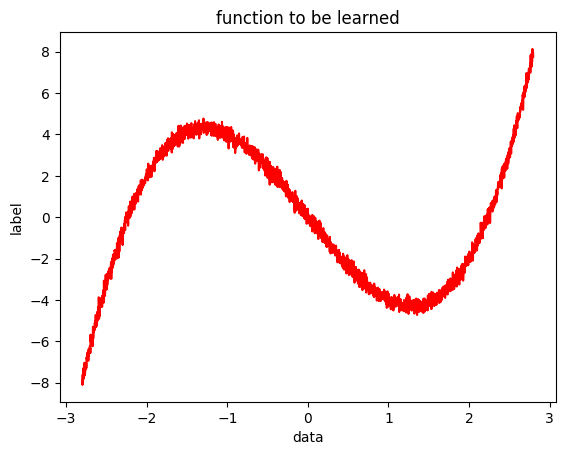

In [236]:
### Label generating function to be learned

def f (x):
  return x*x*x -5*x # simple polynomial of third degree

# plot function
data = np.arange(SUPPORT[0],SUPPORT[1],PITCH)
label = f(data)

# add label noise
if NOISE:
  add_noise = np.random.normal(0,0.2,data.shape) # The noise level can be modified.
  label+=add_noise

plt.plot(data, label, color='red')
plt.title("function to be learned")
plt.xlabel('data')
plt.ylabel('label')
plt.show()

## Data distribution
We now have data $(x,y)$ where $x$ is the data and $y$ the corresponding label. We now have to distribute the data across our nodes.

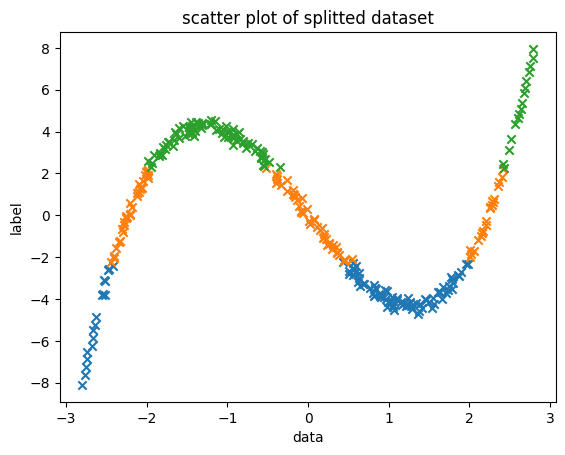

In [237]:
### create datasets

glob_dataset = np.hstack((data[:,np.newaxis], label[:,np.newaxis]))
indices = np.argsort(glob_dataset[:,1])
glob_dataset = np.asarray([(glob_dataset[i,0],glob_dataset[i,1]) for i in indices])

# split dataset in N parts
split = np.array_split(glob_dataset, N)
for sub_set in split:
  plt.scatter(sub_set[:,0],sub_set[:,1], marker='o')
plt.title("scatter plot of splitted dataset")
plt.xlabel('data')
plt.ylabel('label')
plt.show()



## Non-IIDness of datasplit
An identically distributed split would mean, that each split would have been sampled from the same distribution. In this example this would translate to a uniform sampling of datapoints within the support of the function. This is equivalent to randomly assigning an equal amount of data, label pairs to the nodes.
This obviously is not the case here. Independent of the Node, since the underlying function is the same on each node, each $x$ is translated to roughly the same $y$ and vice versa. Thus $P_i(y|x)$ and $P_i(x|y)$ is the same for each Node, so we don't have a concept shift or drift. What does vary is the distribution of the labels $P_i(y)$ and the distribution of the feature $P_i(x)$, thus we do have a Prior and Covariance shift.

## Defining our model
After we have our function and split our data, we now need a model to approximate the function.
Here we will use a very simple feed forward network with two hidden layers and 16 neurons per hidden layer. Since a multiple times continuously differentiable function is approximated, a Sigmoid function is used as activation function.

In [238]:
### set hyper parameter

NEURONS_PER_LAYER = 16 # number of nodes in the hidden layer
RANDOM_SEED = 7 # seed for random initialization

In [239]:
### define two layer feed forward network

class FFN(nn.Module):
    def __init__(self,n, seed):
      super(FFN, self).__init__()
      torch.manual_seed(seed)
      self.fc1 = nn.Linear(1, n,True)
      self.sig1 = nn.Sigmoid()
      self.fc2 = nn.Linear(n,n,True)
      self.sig2 = nn.Sigmoid()
      self.fc3 = nn.Linear(n,1,False)


    def forward(self,x):

      x = self.fc1(x)
      x = self.sig1(x)
      x = self.fc2(x)
      x = self.sig2(x)
      x = self.fc3(x)

      return x

data size : torch.Size([2800, 1])


100%|██████████| 1500/1500 [00:03<00:00, 403.79it/s]


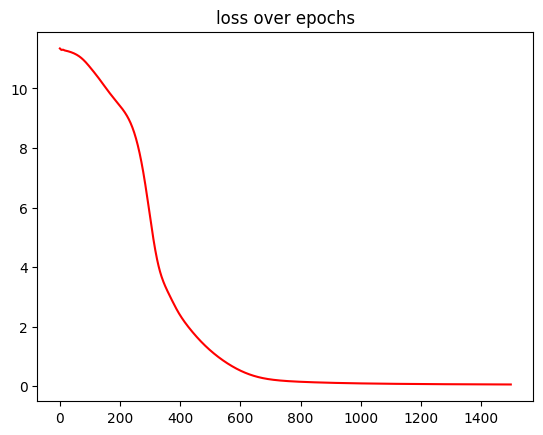

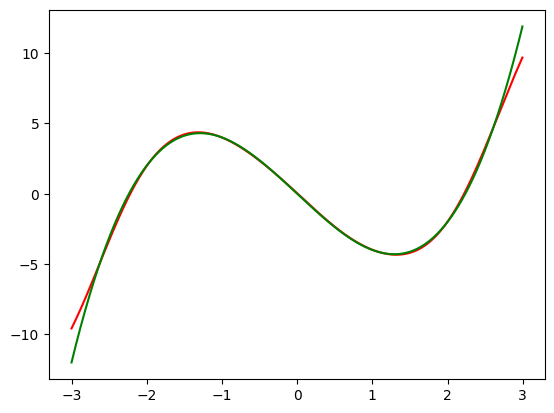

In [240]:
### test global model performance

glob_model = FFN(NEURONS_PER_LAYER, RANDOM_SEED)
glob_model.double()

# define training hyper parameter
loss_fn = nn.MSELoss()
optimizer = opt.SGD(glob_model.parameters(), lr=0.01, momentum=0.9)
NUM_EPOCHS  = 1500

# setup trainings pipeline

# Training function
def train(model, data, labels, max_epochs):
  epochs = []
  trainloss = []
  data = torch.from_numpy(data[:,np.newaxis])
  print(f"data size : {data.shape}")
  labels = torch.from_numpy(labels[:,np.newaxis])
  for epoch in tqdm(range(max_epochs)):
    epochs.append(epoch)
    optimizer.zero_grad()
    pred = model(data)
    loss = loss_fn(pred,labels)
    loss.backward()
    optimizer.step()
    trainloss.append(loss.detach().numpy())
    """for i, (input, label) in enumerate(zip(data,labels)):

      # zero the parameter gradients
      optimizer.zero_grad()
      # predict y
      pred = model(input)
      # compute the loss based on model output and real labels
      loss = loss_fn(pred, label)
      # save trainingsloss for statistic
      train_loss += loss
      # backpropagate the loss
      loss.backward()
      # adjust parameters based on the calculated gradients
      optimizer.step()

    # compute average trainingsloss
    trainloss.append(train_loss.detach()/n_train)"""

  epochs = np.asarray(epochs)
  trainloss = np.asarray(trainloss)
  return epochs, trainloss

epochs, train_loss = train(glob_model,glob_dataset[:,0],glob_dataset[:,1],NUM_EPOCHS)

### plot training stats

plt.plot(epochs, train_loss, color='red')
plt.title("loss over epochs")
plt.show()

# plot prediction
data_test = np.arange(-3,3,0.005)
with torch.no_grad():
  y_pred = glob_model(torch.from_numpy(data_test[:,np.newaxis]))

y_exact = f(data_test)

plt.plot(data_test, y_pred.detach().numpy(), color='red')
plt.plot(data_test, f(data_test), color='green')
plt.show()




In [241]:
### fed parameters

MAX_ROUNDS = 50 # number of federated learning rounds T
MAX_EPOCH = 1000 # number od epochs per round

  0%|          | 0/20 [00:00<?, ?it/s]

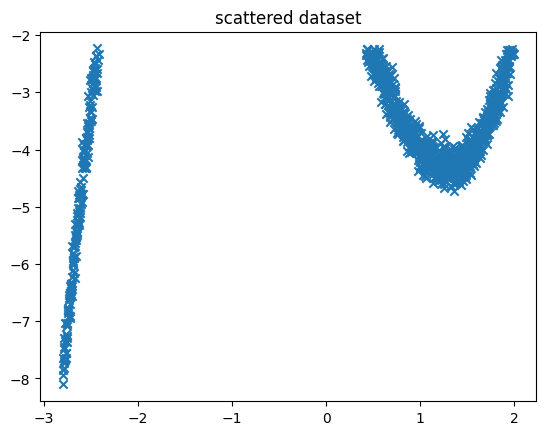

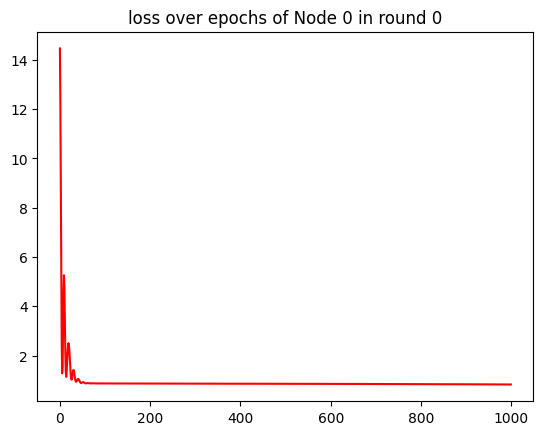

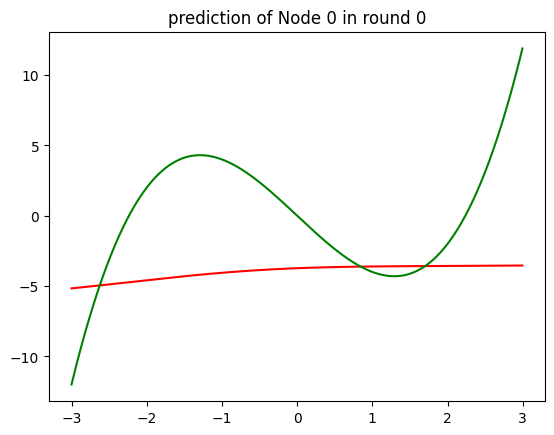

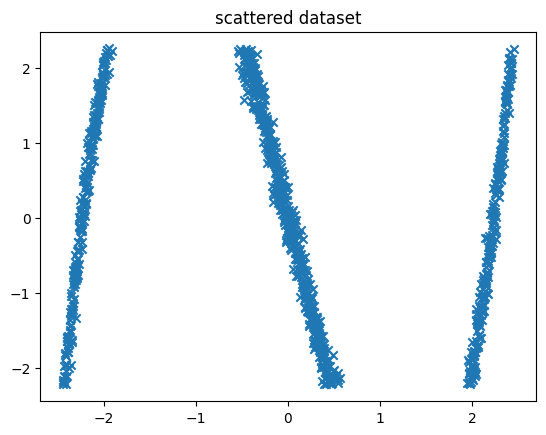

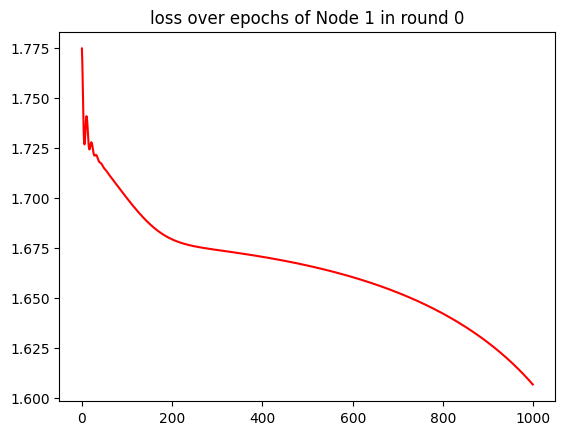

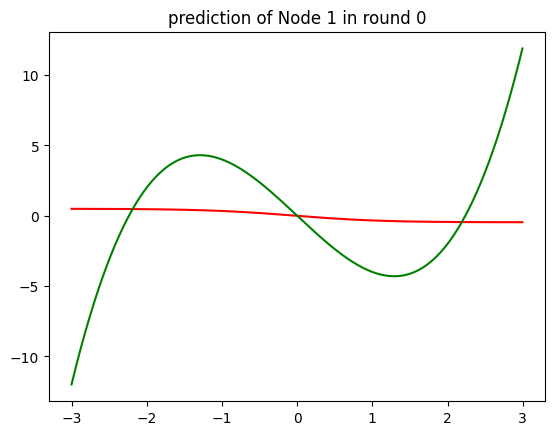

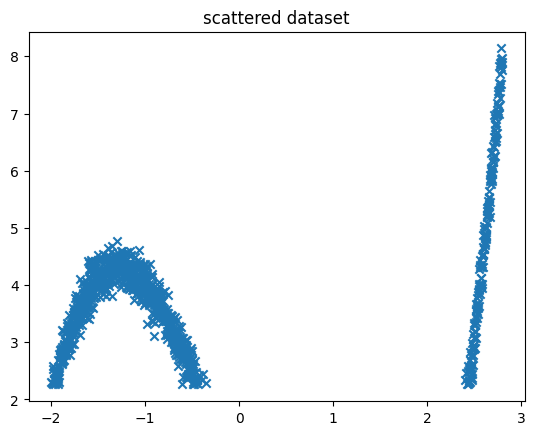

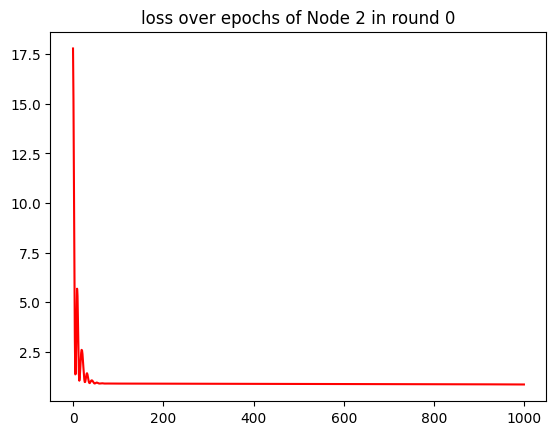

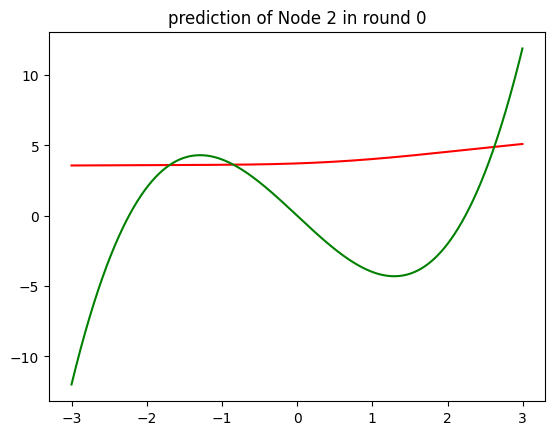

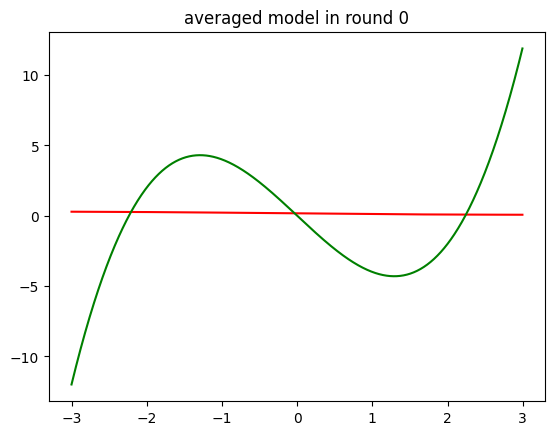

  5%|▌         | 1/20 [00:16<05:12, 16.46s/it]

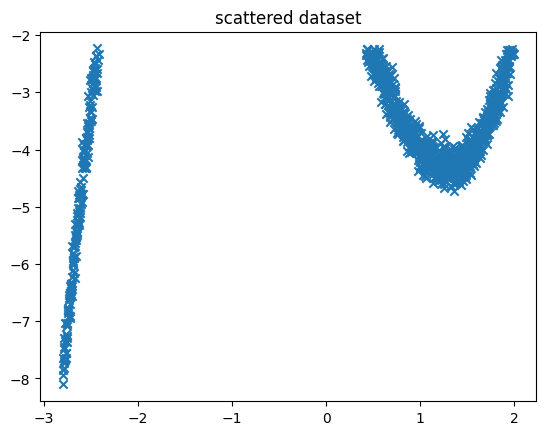

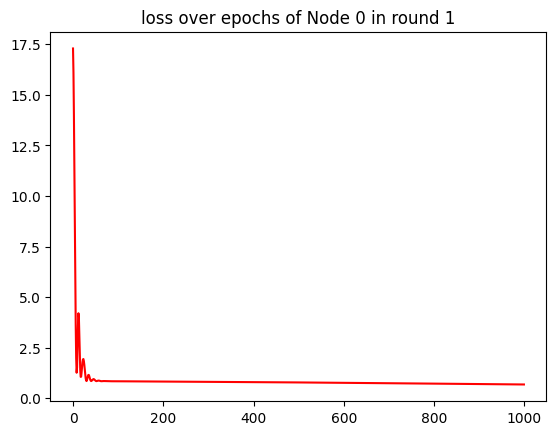

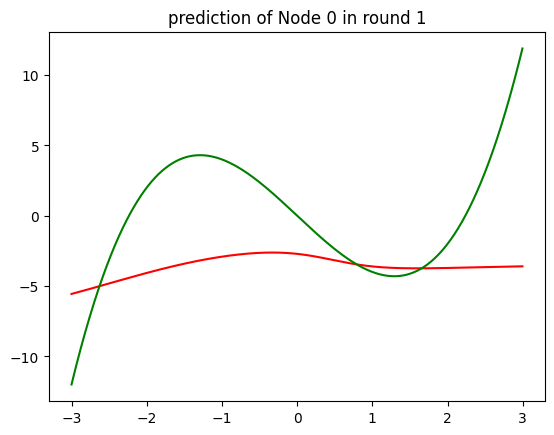

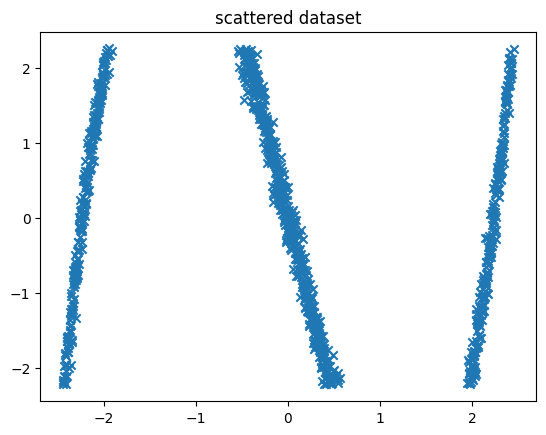

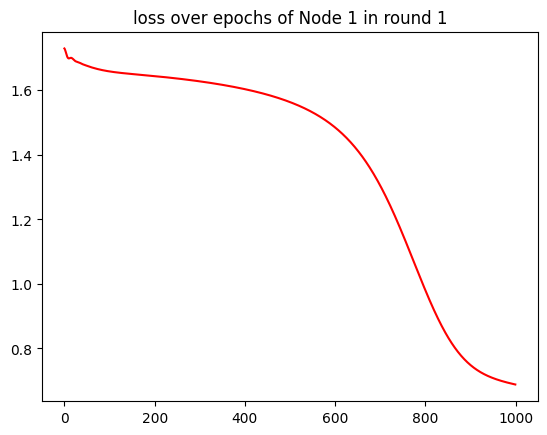

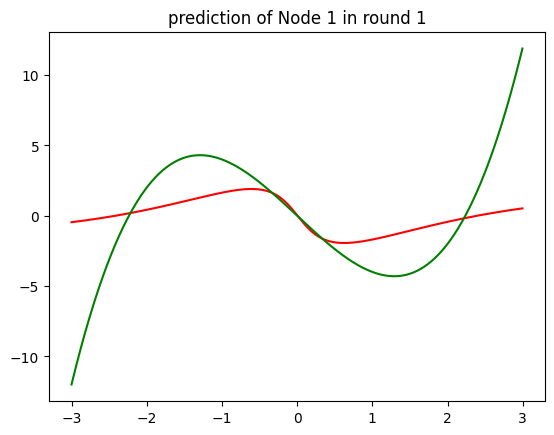

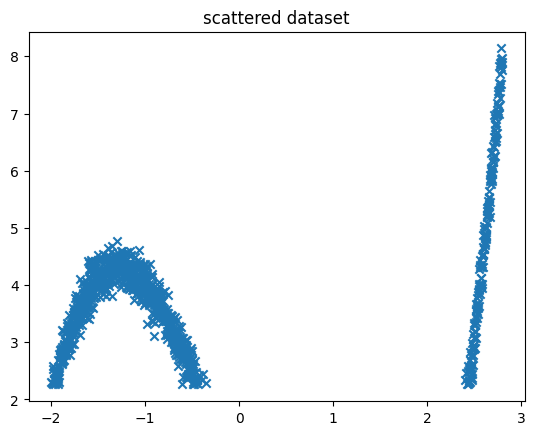

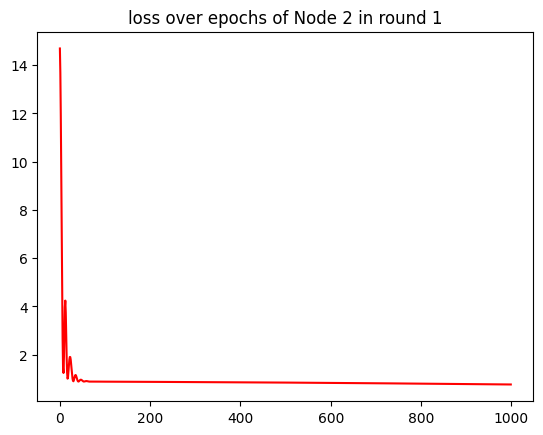

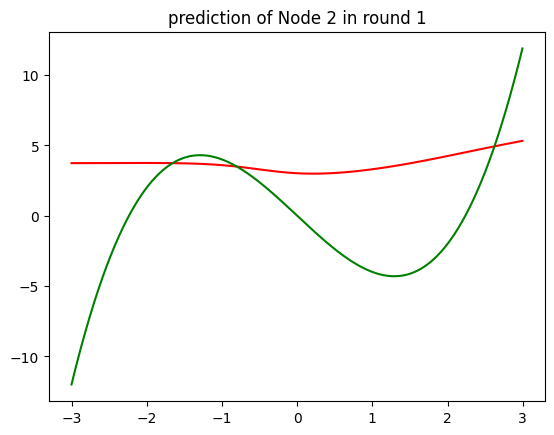

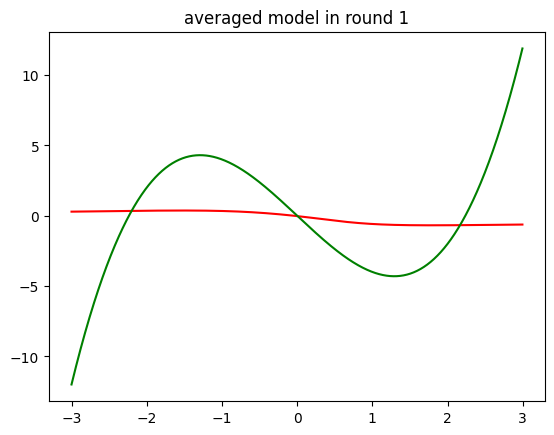

 10%|█         | 2/20 [00:26<03:53, 12.97s/it]

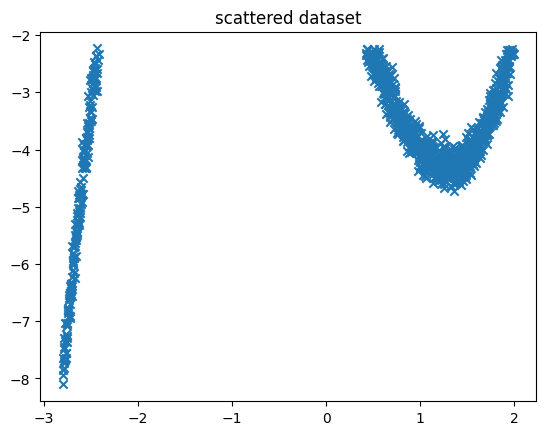

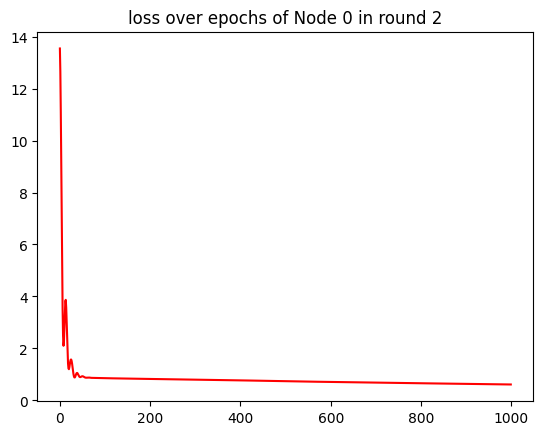

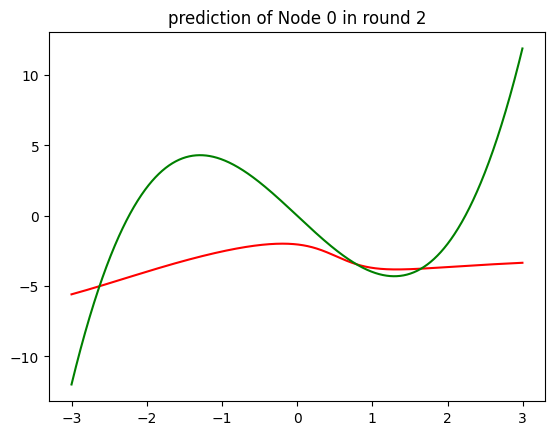

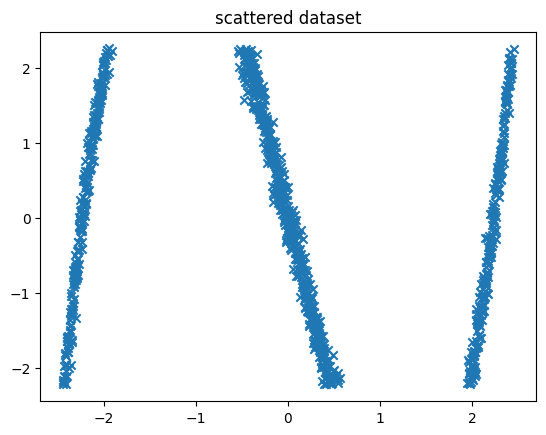

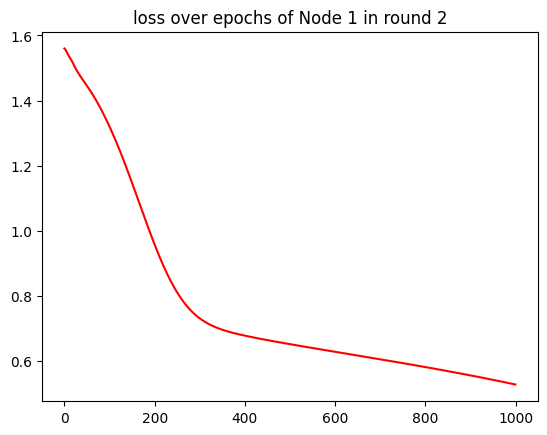

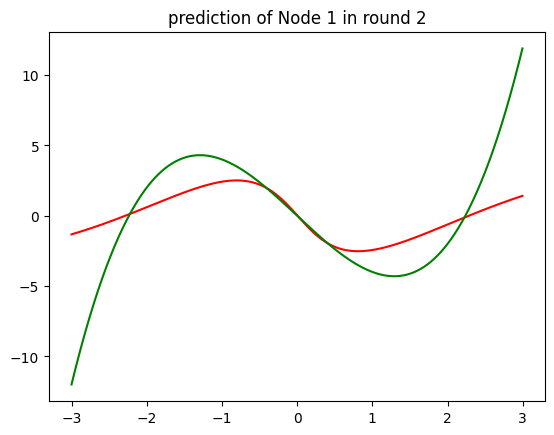

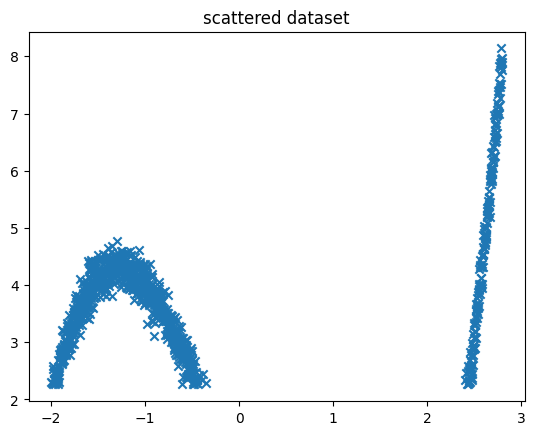

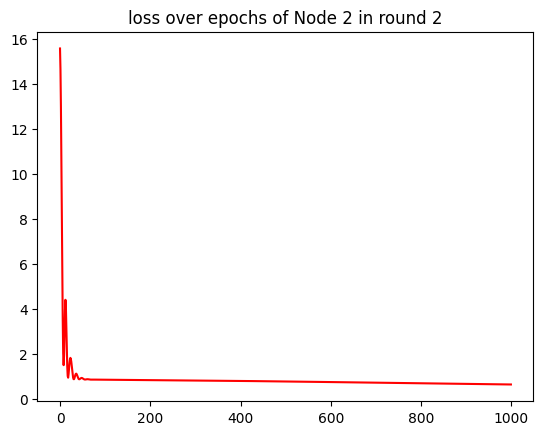

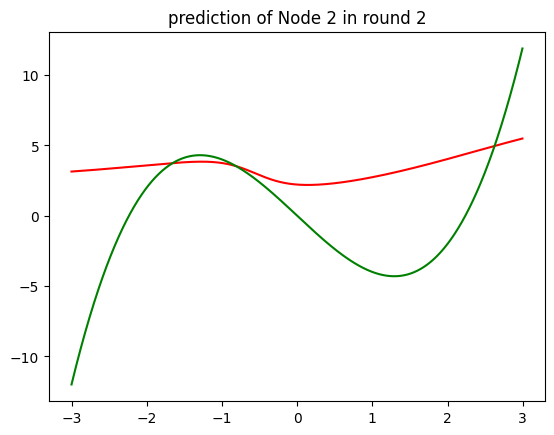

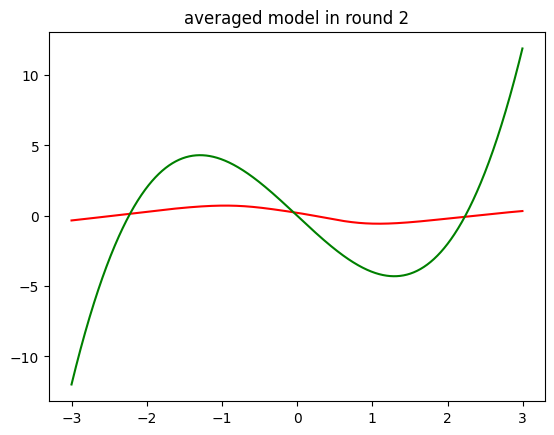

100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


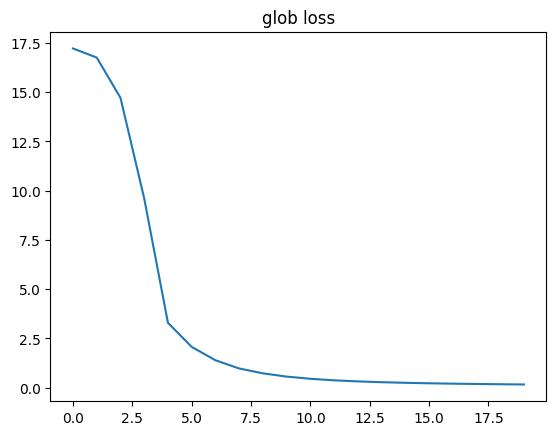

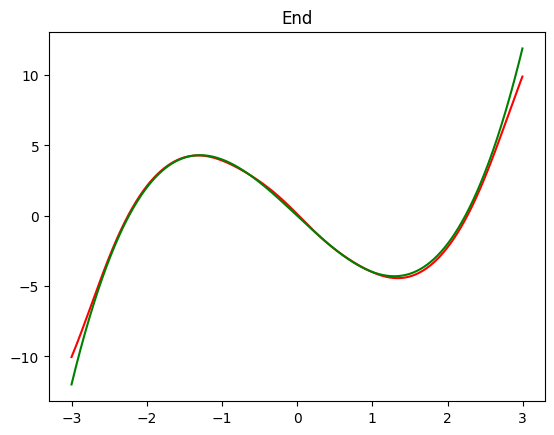

In [242]:
### fed first shot

# params for visualization
RESUME_TO_ENDE=False

# init global model
glob_model = FFN(NEURONS_PER_LAYER, RANDOM_SEED)
glob_model.double()
loss_fn = nn.MSELoss()

# init local models
loc_models = []
loc_optimizers = []
for k in range(N):
  loc_models.append(FFN(NEURONS_PER_LAYER,10).double())
  loc_optimizers.append(opt.SGD(loc_models[k].parameters(), lr=0.001, momentum=0.9))

# prepare data
if type(split[0]) is np.ndarray:
  for k in range(N):
    split[k]=torch.from_numpy(split[k])

# define training function
def train(model, data, labels, opt, max_epochs):
  epochs = []
  trainloss = []
  for epoch in tqdm(range(max_epochs)):
    epochs.append(epoch)
    opt.zero_grad()
    pred = model(data)
    loss = loss_fn(pred,labels)
    loss.backward()
    opt.step()
    trainloss.append(loss.detach().numpy())

  epochs = np.asarray(epochs)
  trainloss = np.asarray(trainloss)
  return epochs, trainloss

# start training rounds
for trainings_round in range(MAX_ROUNDS):
  print(f"start round {trainings_round}")

  # pull from global model
  for k in range(N):
    loc_models[k].load_state_dict(glob_model.state_dict())

  # train local models
  nodes_epoch = []
  nodes_loss = []
  for loc_dataset, loc_model, loc_opt in zip(split,loc_models, loc_optimizers):
    loc_data = loc_dataset[:,0,None]
    loc_label = loc_dataset[:,1,None]
    loc_epochs, loc_trainloss = train(loc_model,loc_data,loc_label,loc_opt,MAX_EPOCH)
    nodes_epoch.append(loc_epochs)
    nodes_loss.append(loc_trainloss)

  # print output
  if RESUME_TO_ENDE is False:
    verbose = input("show loss and prediction? [Y/N]")
    if verbose == 'Y' or verbose == 'y':
      for k, node_epoch, node_loss, loc_model in zip(range(N),nodes_epoch,nodes_loss, loc_models):
        # plot loss
        plt.plot(node_epoch, node_loss, color='red')
        plt.title(f"loss over epochs of Node {k} in round {trainings_round}")
        plt.show()

        # plot prediction
        data_test = np.arange(-3,3,0.005)
        with torch.no_grad():
          y_pred = loc_model(torch.from_numpy(data_test[:,np.newaxis]))
        y_exact = f(data_test)
        plt.plot(data_test, y_pred.detach().numpy(), color='red')
        plt.plot(data_test, f(data_test), color='green')
        plt.title(f"prediction of Node {k} in round {trainings_round}")
        plt.show()
  resume = input("resume rest of rounds? [Y/N]")
  if resume == 'Y' or resume=='y':
    RESUME_TO_ENDE = True

  # pool models
  glob_weights = 0



